In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

import pprint as pp
from joblib import dump, load

from sklearn.metrics import accuracy_score

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
csv_file = '../content/gdrive/My Drive/NLP-data/books_reviews.csv'
df = pd.read_csv(csv_file)

In [0]:
df['rating'] = df['rating'].astype('category')

In [0]:
def binary_labels(df, min_set=None, avoid_index=None):
 
    # Cleanning data set
    count = df['review_text'].str.len()
    df = df[(count > 3) | (count < 4000)].copy()
    
    if avoid_index is not None:
        df = df[~df.index.isin(avoid_index)].copy()
    
    # Equilize dataset sample size
    if min_set is None:
        min_set = df['rating'].value_counts().min() * 4
    
    # Split rating 1.0, 2.0 as negative reviews
    rating_1 = df[df['rating'] == 1.0].iloc[:min_set // 4]
    rating_2 = df[df['rating'] == 2.0].iloc[:min_set // 4]
    negative_reviews = pd.concat([rating_1, rating_2])
    negative_reviews['label'] = 0
    
    # Split rating 4.0, 5.0 as positive reviews
    rating_4 = df[df['rating'] == 4.0].iloc[:min_set // 4]
    rating_5 = df[df['rating'] == 5.0].iloc[:min_set // 4]
    positive_reviews = pd.concat([rating_4, rating_5])
    positive_reviews['label'] = 1
    
    dataset = pd.concat([negative_reviews, positive_reviews])
    dataset.sort_index(inplace=True)
    
    return dataset

avoid_index = load('../content/gdrive/My Drive/NLP-data/dataset_index.joblib')
unseen_dataset = binary_labels(df,  min_set=50000, avoid_index=avoid_index)
training_dataset = binary_labels(df,  min_set=50000)[:45000].copy()

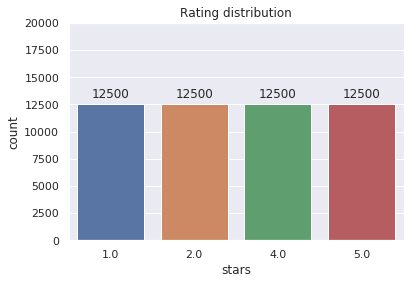

In [0]:
def plot_rating_dist(df, x='rating', title='Rating distribution', xlabel='stars', ylim=700000):
    ax = sns.countplot(x=x, data=df)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    for rect in ax.containers[0]:
        tw = rect.get_width() / 2.
        tx = rect.get_x() + tw
        height = rect.get_height()
        ty = 1.05 * height
        ax.text(tx, ty, height, ha='center')

    ax.set_ylim(0, ylim)
    
plot_rating_dist(unseen_dataset, ylim=20000)

In [0]:
# load models
from keras.models import load_model
from collections import defaultdict

model = defaultdict(dict)

model['CNN_01']['model'] = load_model('../content/gdrive/My Drive/NLP-data/CNN_model_weights_last_epoch.hdf5')
model['CNN_01']['embedding'] = 'glove.6B.100d'
model['CNN_02']['model']  = load_model('../content/gdrive/My Drive/NLP-data/CNN_no_embedding_last_epoch.hdf5')
model['CNN_02']['embedding'] = None
model['FASTTEXT_NG1']['model']  = load_model('../content/gdrive/My Drive/NLP-data/Fasttext_ng1_100emb_model_weights_last_epoch.hdf5')
model['FASTTEXT_NG1']['embedding'] = None
model['FASTTEXT_NG2']['model']  = load_model('../content/gdrive/My Drive/NLP-data/Fasttext_ng2_100emb_model_weights_last_epoch.hdf5')
model['FASTTEXT_NG2']['embedding'] = None
model['LSTM_01']['model']  = load_model('../content/gdrive/My Drive/NLP-data/LSTM_model_weights_last_epoch.hdf5')
model['LSTM_01']['embedding'] = 'glove.6B.100d'
model['LSTM_02']['model']  = load_model('../content/gdrive/My Drive/NLP-data/LSTM_no_embedding_last_epoch.hdf5')
model['LSTM_02']['embedding'] = None

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 124804300 elements. This may consume a large amount of memory.
  num_elements)


In [0]:
def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [0]:
from keras.preprocessing.sequence import pad_sequences

def prepare_input(df, lstm_cnn=False, ngram=1):
    print('loading tokenizer...')
    
    if lstm_cnn is True:
        tokenizer = load('../content/gdrive/My Drive/NLP-data/tokenizer_lstm_cnn.joblib')
    else:
        tokenizer = load('../content/gdrive/My Drive/NLP-data/tokenizer_fasttext.joblib')
    
    print('word_index size:', len(tokenizer.word_index))
    token_indice = load('../content/gdrive/My Drive/NLP-data/token_indice_fasttext.joblib')
    
    print('processing sequences...')
    sequences = tokenizer.texts_to_sequences(df['review_text'])
    
    if ngram > 1:
        sequences = add_ngram(sequences, token_indice, ngram)
    
    print('padding sequences...')
    data = pad_sequences(sequences, maxlen=400)
    return data

In [0]:
%%time

lstm_cnn_trainning = prepare_input(training_dataset, lstm_cnn=True, ngram=1)
lstm_cnn_unseen = prepare_input(unseen_dataset, lstm_cnn=True, ngram=1)

fasttext_ng1_training = prepare_input(training_dataset, lstm_cnn=False, ngram=1)
fasttext_ng1_unseen = prepare_input(unseen_dataset, lstm_cnn=False, ngram=1)

fasttext_ng2_training = prepare_input(training_dataset, lstm_cnn=False, ngram=2)
fasttext_ng2_unseen = prepare_input(unseen_dataset, lstm_cnn=False, ngram=2)

model['CNN_01']['training'] = lstm_cnn_trainning
model['CNN_01']['unseen'] = lstm_cnn_unseen
model['CNN_02']['training'] = lstm_cnn_trainning
model['CNN_02']['unseen'] = lstm_cnn_unseen
model['FASTTEXT_NG1']['training'] = fasttext_ng1_training
model['FASTTEXT_NG1']['unseen'] = fasttext_ng1_unseen
model['FASTTEXT_NG2']['training'] = fasttext_ng2_training
model['FASTTEXT_NG2']['unseen'] = fasttext_ng2_unseen
model['LSTM_01']['training'] = lstm_cnn_trainning
model['LSTM_01']['unseen'] = lstm_cnn_unseen
model['LSTM_02']['training'] = lstm_cnn_trainning
model['LSTM_02']['unseen'] = lstm_cnn_unseen

loading tokenizer...
word_index size: 87719
processing sequences...
padding sequences...
loading tokenizer...
word_index size: 87719
processing sequences...
padding sequences...
loading tokenizer...
word_index size: 96740
processing sequences...
padding sequences...
loading tokenizer...
word_index size: 96740
processing sequences...
padding sequences...
loading tokenizer...
word_index size: 96740
processing sequences...
padding sequences...
loading tokenizer...
word_index size: 96740
processing sequences...
padding sequences...
CPU times: user 1min 42s, sys: 857 ms, total: 1min 43s
Wall time: 1min 43s


In [0]:
for name in list(model.keys()):
    print(name)
    print('training data')
    predict_training = model[name]['model'].predict(model[name]['training']).round()
    print('unseen data')
    predict_unseen = model[name]['model'].predict(model[name]['unseen']).round()
    print('getting scores')
    training_score = accuracy_score(training_dataset['label'], predict_training)
    unseen_score = accuracy_score(unseen_dataset['label'], predict_unseen)
    model[name]['training score'] = training_score
    print(name, 'training score', f'{training_score * 100:.1f}%')
    model[name]['unseen score'] = unseen_score
    print(name, 'unseen score', f'{unseen_score * 100:.1f}%')

CNN_01
training data
unseen data
getting scores
CNN_01 training score 95.1%
CNN_01 unseen score 89.5%
CNN_02
training data
unseen data
getting scores
CNN_02 training score 99.4%
CNN_02 unseen score 92.4%
FASTTEXT_NG1
training data
unseen data
getting scores
FASTTEXT_NG1 training score 98.6%
FASTTEXT_NG1 unseen score 92.3%
FASTTEXT_NG2
training data
unseen data
getting scores
FASTTEXT_NG2 training score 99.8%
FASTTEXT_NG2 unseen score 95.0%
LSTM_01
training data
unseen data
getting scores
LSTM_01 training score 96.5%
LSTM_01 unseen score 92.4%
LSTM_02
training data
unseen data
getting scores
LSTM_02 training score 99.6%
LSTM_02 unseen score 91.4%


In [0]:
results = pd.DataFrame()
results['model'] = list(model.keys())
results['embeddings'] = [v['embedding'] for _, v in model.items()]
results['training score'] = [v['training score'] for _, v in model.items()]
results['unseen score'] = [v['unseen score'] for _, v in model.items()]

In [0]:
results['training score'] = results['training score'].apply(lambda x: f'{x * 100:.1f}%')
results['unseen score'] = results['unseen score'].apply(lambda x: f'{x * 100:.1f}%')

In [0]:
results.set_index('model')

,embeddings,training score,unseen score
model,,,
CNN_01,glove.6B.100d,95.1%,89.5%
CNN_02,None,99.4%,92.4%
FASTTEXT_NG1,None,98.6%,92.3%
FASTTEXT_NG2,None,99.8%,95.0%
LSTM_01,glove.6B.100d,96.5%,92.4%
LSTM_02,None,99.6%,91.4%
